---
title: Text classification
author: Jamel Belgacem
date: 'July 12, 2023'
categories: [Deep learning, Text classification]
image: "image_cancer.jpg"
format:
    html:
        code-fold: true
        code-tools: true
        code-link: true
---

Text classification with deep learning leverages the power of deep neural networks to automatically extract complex features from textual data. By using techniques like recurrent neural networks (RNNs), convolutional neural networks (CNNs), or transformer models, deep learning enables accurate and efficient categorization of text into predefined classes, making it a robust and widely adopted approach in natural language processing tasks.

For this tutorial we will use tha cancer data from [Kaggle](https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification). Based on biomedical text documentation, I will train a neural network to predict the type of cancer.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import collections
#nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

### Read data
The dataset are composed of two columns:
- Type: Cancer name (Thyroid_Cancer, Colon_Cancer, Lung_Cancer)
- Text: Description of the cancer

In [2]:
data = pd.read_csv('data/alldata_1_for_kaggle.csv', sep=','
                   ,header=0, encoding='mac_latin2',
                   usecols=[1,2],names=['Type', 'Text'])
data.head(10)

,Type,Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis Ô¨Āb...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...
5,Thyroid_Cancer,This study was performed to explore the effec...
6,Thyroid_Cancer,This study was performed assess the clinical ...
7,Thyroid_Cancer,Journal of International Medical Research ď Th...
8,Thyroid_Cancer,Gastric cancer GC persists as a worldwide pub...
9,Thyroid_Cancer,Scars Burns HealingVolume ď reuse guideli...


In [3]:
data['Type'].value_counts()

Type
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64

### Data preparation:
Before injecting texts into the model, we have to clean our data:

1- Remove ponctuations

2- Remove numbers

3- Transform to lower case

4- Remove stop words like an, on, at, ...

5- Remove spaces

This step will be time-consuming due to the lengthy text.

> stop words:

In [17]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:
def transform(text):
    # Remove ponctuations
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub('',text)
    # Remove numbers
    text = re.sub(r'[0-9]', ' ', text)
    # To lower case
    text = text.lower()
    # Remove stop words
    text = ' '.join([i for i in text.split() if i not in stopwords.words('english') and len(i)>2])
    # Remove spaces
    text = re.sub(r'\s+', ' ', text)
    return(text)

data['Text_cleaned'] = data['Text'].apply(lambda x: transform(x))

In [5]:
print('Before transform function:', end='\n')
print(data.iloc[1,1], end='\n\n')
print('After transform function:', end='\n')
print(data.iloc[1,2])

Before transform function:
" The adopted strategy was the same as that used in prior years [] and is based on four exclusive queries that return  four  disjoint  citation  subsets The first query QPub_plain is based on a plaintext search in PubMed titles and s using keywords The  second  query  QPub_indexed relies on the PubMed indexing scheme using MeSH terms and results are made exclusive of the previous set The third one QWoS_restricted is based on a plaintext search in WoS restricted to the two research areas úMedical InformaticsĚ and úHealth Care Sciences  ServicesĚ The fourth query QWoS_filtered is based on the same plaintext search used in WoS but filtered by nonrelevant research areas eg Archeology Dance Zoology etc and the two research areas of the previous query It is of note that the two WoS queries select  only  nonPubMedindexed  papers that are supposed to be caught by the two PubMed queriesA  first  review  of  the  four  subsets  of retrieved  citations  was  performed  

### WordCloud plots
I can't resist to draw some wordcloud.

A __word cloud__ plot is a popular visualization technique that displays the most frequently occurring words in a text corpus. It visually represents the importance of words by varying the size of each word according to its frequency, offering a quick and insightful overview of the most prominent terms within the given dataset.

With all the type of cancer:

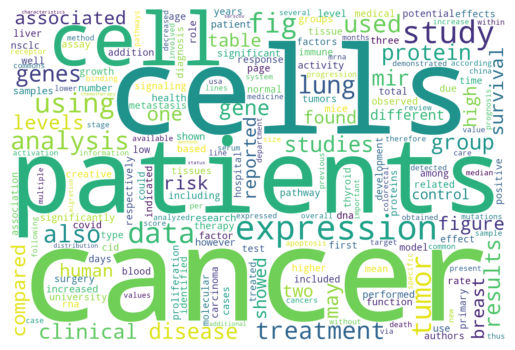

In [6]:
text = ' '.join(i for i in data['Text_cleaned'])
words = text.split()
word_counts_dict=collections.Counter(words)
wordcloud=WordCloud(width=1200, height=800, background_color='white', max_words=200)
wordcloud.generate_from_frequencies(word_counts_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Thyroid cancer:

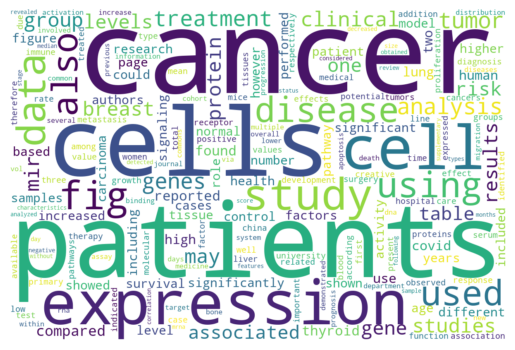

In [7]:
text = ' '.join(i for i in data[data['Type']=='Thyroid_Cancer']['Text_cleaned'])
words = text.split()
word_counts_dict=collections.Counter(words)
wordcloud=WordCloud(width=1200, height=800, background_color='white', max_words=200)
wordcloud.generate_from_frequencies(word_counts_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Cancer of colon:

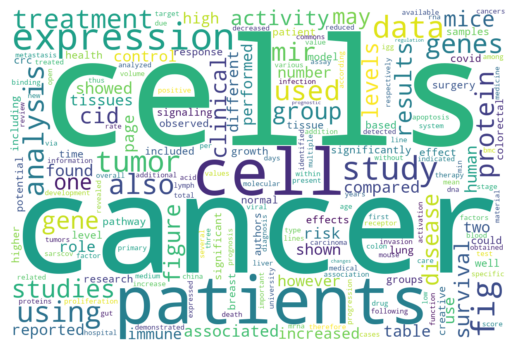

In [8]:
text = ' '.join(i for i in data[data['Type']=='Colon_Cancer']['Text_cleaned'])
words = text.split()
word_counts_dict=collections.Counter(words)
wordcloud=WordCloud(width=1200, height=800, background_color='white', max_words=200)
wordcloud.generate_from_frequencies(word_counts_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Lung cancer:

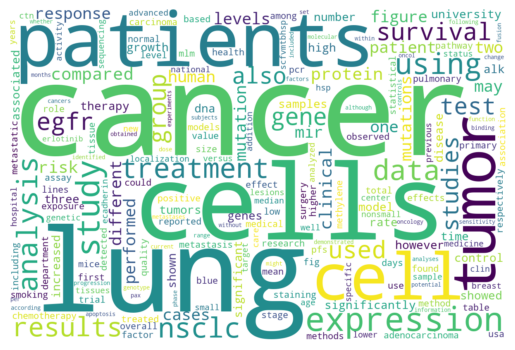

In [9]:
text = ' '.join(i for i in data[data['Type']=='Lung_Cancer']['Text_cleaned'])
words = text.split()
word_counts_dict=collections.Counter(words)
wordcloud=WordCloud(width=1200, height=800, background_color='white', max_words=200)
wordcloud.generate_from_frequencies(word_counts_dict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

>As we can see on the previous plot, some words like Cancer, cell and patient are frequently used with all the cancer type. I have to use more than 200 words if I want a good accuracy of my model.

### Modelization
Before setting the model, I splitted my data in two:
- train: to train the model
- test: to test the accuracy of the model.

After that, we'll use this technics:
- Tokenizer: to transform list of words into list of integers as keras is dealing only with numbers.
- Padding: to transform list of numbers into 2d numpy array with the same size (longest sequence in the list)
- Label encoder: to transform labels (cancer type) to integers

In [10]:
label_encoder = LabelEncoder()
x_train, x_test, y_train, y_test =train_test_split(data['Text_cleaned'], data['Type'], test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Text_cleaned'])

max_seq_length = 1000
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(x_train_seq, maxlen=max_seq_length)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(x_test_seq, maxlen=max_seq_length)

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.fit_transform(y_test)

As input, the first layer will be an embedding with:
- input dimensions of 5000 as we'll use the 5000 words most frequent
- output dimensions are 256
- input length is 1000 (sentence's length is 1000)

The model starts with an Embedding layer, followed by a Dropout layer to prevent overfitting.

Next, a Conv1D layer with MaxPooling1D is used to capture local patterns in the text. A Bidirectional LSTM layer is incorporated to capture contextual information from both directions. BatchNormalization and additional Dropout layers are added to improve training stability and generalization.

Finally, the model has a dense output layer with softmax activation for multi-class classification. The model is compiled using the Adam optimizer with a learning rate of 1e-4 and sparse categorical cross-entropy loss for the specified metrics of accuracy. 

In [11]:
model=Sequential()
model.add(Embedding(input_dim=5000, output_dim=256, input_length=1000))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='selu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 256)         1280000   
                                                                 
 dropout (Dropout)           (None, 1000, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, 998, 64)           49216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 64)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 128)              5

In [12]:
y_train_enc = y_train_enc.astype(float)
history = model.fit(x_train_seq, y_train_enc, validation_split=0.2, batch_size=100, epochs=15, verbose=1)

Epoch 1/15


2023-07-31 11:50:45.465002: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


49/49 [==============================] - 26s 497ms/step - loss: 1.0103 - accuracy: 0.5772 - val_loss: 1.0668 - val_accuracy: 0.4868
Epoch 2/15
49/49 [==============================] - 27s 550ms/step - loss: 0.5593 - accuracy: 0.7779 - val_loss: 1.0341 - val_accuracy: 0.3927
Epoch 3/15
49/49 [==============================] - 27s 559ms/step - loss: 0.2615 - accuracy: 0.9147 - val_loss: 0.9631 - val_accuracy: 0.4909
Epoch 4/15
49/49 [==============================] - 26s 527ms/step - loss: 0.1250 - accuracy: 0.9649 - val_loss: 0.8665 - val_accuracy: 0.6832
Epoch 5/15
49/49 [==============================] - 25s 508ms/step - loss: 0.0757 - accuracy: 0.9802 - val_loss: 0.7447 - val_accuracy: 0.8177
Epoch 6/15
49/49 [==============================] - 24s 483ms/step - loss: 0.0532 - accuracy: 0.9862 - val_loss: 0.5993 - val_accuracy: 0.9307
Epoch 7/15
49/49 [==============================] - 26s 526ms/step - loss: 0.0418 - accuracy: 0.9884 - val_loss: 0.4467 - val_accuracy: 0.9827
Epoch 8/15

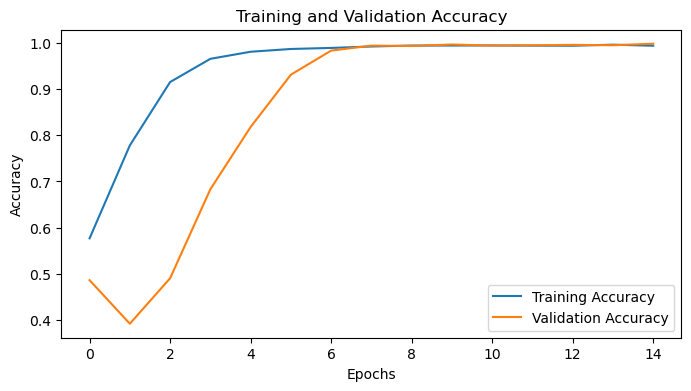

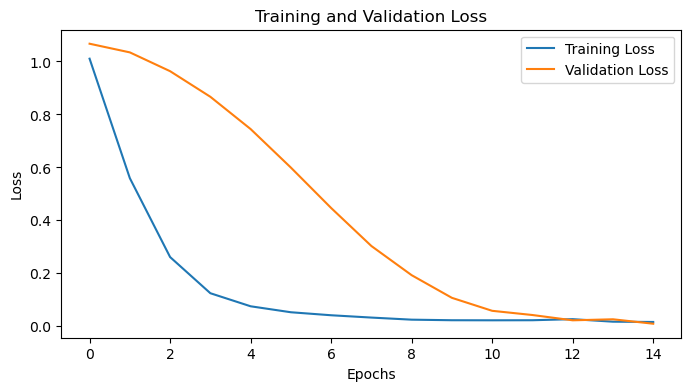

In [13]:
# Get the training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Get the training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Accuracy of trained model:
All right we have trained our model, now let's apply it to the test dataset and display the accuracy:

In [14]:
accuracy = model.evaluate(x_test_seq, y_test_enc)
print(f"Accuracy of the trained model: {(100*accuracy[1]):.2f} %")

48/48 [==============================] - 2s 36ms/step - loss: 0.0144 - accuracy: 0.9941
Accuracy of the trained model: 99.41 %


#### Confusion matrix
A confusion matrix is a fundamental tool in the field of machine learning and classification tasks.

It provides a comprehensive and intuitive representation of the performance of a classification model by comparing its predicted class labels with the actual ground truth labels

48/48 [==============================] - 2s 35ms/step


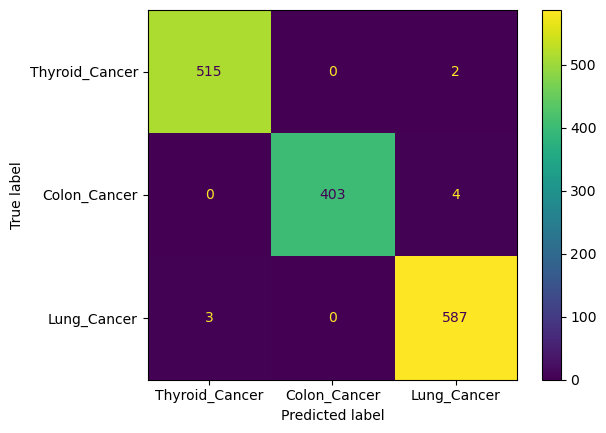

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_prediction = np.argmax(model.predict(x_test_seq), axis=1)
conf_matrix = confusion_matrix(y_true=y_test_enc, y_pred=y_prediction)
class_labels = ['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer']
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot()